In [63]:
%load_ext autoreload
%autoreload 2
import pickle
import os, sys
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm ,colors
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import squareform,pdist
from scipy.stats import zscore, norm, ttest_ind
from scipy.io import loadmat
from sklearn.decomposition import PCA
from copy import deepcopy
root_path = os.path.realpath('../')
sys.path.append(root_path)

from utils import eval, choicemodel, plotting



plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 1: Experiment design and baselines

In [ ]:
plotting.plot_basicstats(models=["baseline_interleaved_new_select", "baseline_blocked_new_select"])

In [ ]:
# interleaved, baseline
# n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('checkpoints/baseline_interleaved_new/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_baseline_int_new.pkl','wb') as f:
#     pickle.dump(xyz, f)


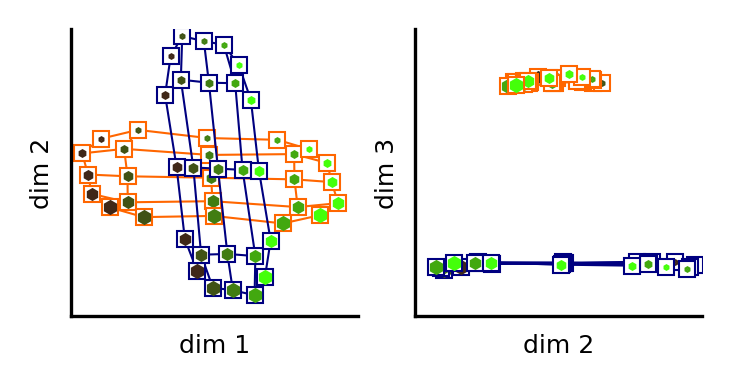

In [59]:
%matplotlib inline
with open('../results/mds_embedding_baseline_int_new.pkl','rb') as f:
    xyz = pickle.load(f)
theta_x = 40
theta_y = 0
theta_z = 10

xyz_rot = eval.rotate(xyz,theta_x,axis='x')
xyz_rot = eval.rotate(xyz_rot,theta_y,axis='y')
xyz_rot = eval.rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plotting.plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=5)

In [ ]:
# # blocked, baseline
# n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('checkpoints/baseline_blocked_new/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_baseline_blocked_new.pkl','wb') as f:
#     pickle.dump(xyz, f)

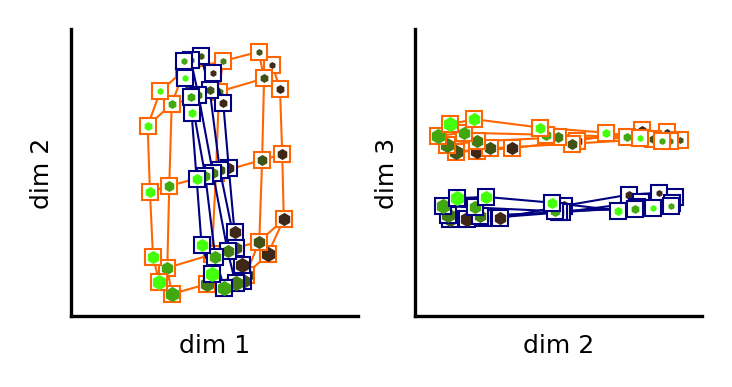

In [60]:

%matplotlib inline
with open('../results/mds_embedding_baseline_blocked_new.pkl','rb') as f:
    xyz = pickle.load(f)
theta_x = -10
theta_y = -10
theta_z = -70

xyz_rot = eval.rotate(xyz,theta_x,axis='x')
xyz_rot = eval.rotate(xyz_rot,theta_y,axis='y')
xyz_rot = eval.rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plotting.plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=4)

## Figure 2: The cost of interleaving

In [ ]:
# choice matrix models

%matplotlib inline
_,_,cmats = eval.gen_behav_models()

f,ax = plt.subplots(2,2, figsize=(2,2),dpi=300)
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(np.flipud(cmats[i,j,:,:]))
        if j<1:
            ax[i,j].set(xlabel='rel',ylabel='irrel')
        else:
            ax[i,j].set(xlabel='irrel',ylabel='rel')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])


In [ ]:
# accuracy (sluggishness)
%matplotlib inline

plotting.plot_sluggish_results(filename="sluggish_baseline_int_select_sv")

## Figure 3: continual learning with manual gating

In [ ]:
# learning curves 
%matplotlib inline
n_runs = 50
models = ['gated_blocked_new_select_cent']

# acc
f1, axs1 = plt.subplots(1,1,figsize=(2.7,2),dpi=300)
f2, axs2 = plt.subplots(1,1,figsize=(2.7,2),dpi=300)
# # choice matrices 
f4, axs4 = plt.subplots(1,2,figsize=(5,5),dpi=300)
# # hidden layer MDS, interleaved
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)
# # hidden layer MDS, blocked
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)


for i,m in enumerate(models):
    t_a = np.empty((n_runs,200))
    t_b = np.empty((n_runs,200))
    t_d = np.empty((n_runs,200))
    t_mixed = np.empty((n_runs,200))
    acc_1st = np.empty((n_runs,200))
    acc_2nd = np.empty((n_runs,200))
    contextcorr = np.empty((n_runs,200))
    cmats_a = []
    cmats_b = []

    for r in range(n_runs):
        with open('../checkpoints/'+m+'/run_'+str(r)+'/results.pkl', 'rb') as f:
            results = pickle.load(f)
            
            # accuracy:
            acc_1st[r,:] = results['acc_1st']
            acc_2nd[r,:] = results['acc_2nd']
            # task factorisation:
            t_a[r,:] = results['n_only_b_regr']/100
            t_b[r,:] = results['n_only_a_regr']/100
            t_d[r,:] = results['n_dead']/100
            t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
            # context correlation:
            contextcorr[r,:] = results['w_context_corr']
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    
    # accuracy
    axs1.plot(np.arange(200),acc_1st.mean(0),color='orange')
    axs1.fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs1.plot(np.arange(200),acc_2nd.mean(0),color='blue')
    axs1.fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    axs1.set_ylim([0.4,1.05])
    axs1.set(xlabel='trial', ylabel='accuracy')
    axs1.legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs1.plot([100,100],[0,1],'k--',alpha=0.5)
    axs1.set_title(m.split('_')[1])
    plt.gcf()
    sns.despine(f1)
    f1.tight_layout()

    # unit allocation
    # unit allocation (task factorisation)
    axs2.plot(np.arange(200),t_b.mean(0),color='orange')
    axs2.fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs2.plot(np.arange(200),t_a.mean(0),color='blue')
    axs2.fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)    
    axs2.set_yticks([0,0.5,1])
    ticks = axs2.get_yticks()#plt.yticks()
    axs2.set_yticklabels((int(x) for x in ticks*100))
    axs2.set(xlabel='trial',ylabel='task-sel (%)')
    axs2.legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs2.plot([100,100],[0,1],'k--',alpha=0.5)
    axs2.set_title(m.split('_')[1])
    plt.gcf()
    sns.despine(f2)
    axs2.set_ylim([0,1.05])    
    f2.tight_layout()

    # choice matrices    
    axs4[0].imshow(cmats_a.mean(0))
    axs4[0].set_title('1st task')
    axs4[0].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='irrel',ylabel='rel')
    axs4[1].imshow(cmats_b.mean(0))
    axs4[1].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='rel',ylabel='irrel')
    axs4[1].set_title('2nd task')
    PCM=axs4[1].get_children()[-2] #get the mappable, the 1st and the 2nd are the x and y axes
    axs4[0].set_xticks([])
    axs4[0].set_yticks([])
    axs4[1].set_xticks([])
    axs4[1].set_yticks([])
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    # plt.colorbar(PCM,cax=cax) 

    # hidden layer MDS 

f1.tight_layout()
f2.tight_layout()
# f3.tight_layout()
f4.tight_layout()



In [ ]:
# hidden layer MDS
# blocked, manual gated
# n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('checkpoints/gated_blocked_new/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_gated_blocked_new.pkl','wb') as f:
#     pickle.dump(xyz, f)
%matplotlib inline
with open('../results/mds_embedding_gated_blocked_new.pkl','rb') as f:
    xyz = pickle.load(f)
theta_x = -20
theta_y = -20
theta_z = -60-90

xyz_rot = eval.rotate(xyz,theta_x,axis='x')
xyz_rot = eval.rotate(xyz_rot,theta_y,axis='y')
xyz_rot = eval.rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=5.2)

## Figure 4: Hebbian learning of context weights 

27


Text(0.5, 1.0, 'Biplot')

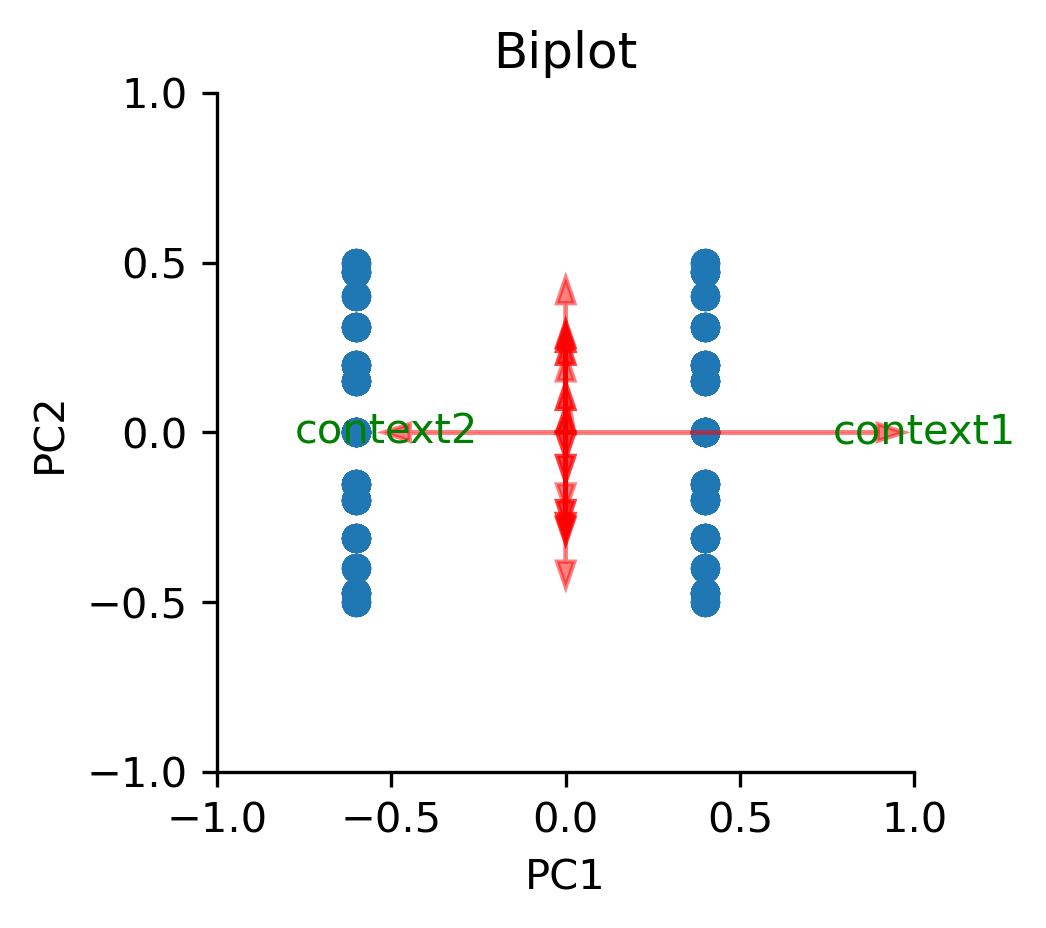

In [54]:
from utils import data
from hebbcl.parameters import parser
args = parser.parse_args(args=[])
args.n_episodes = 10
args.ctx_scaling = 10
args.centering = True
args.ctx_avg = False
# biplot
%matplotlib inline
pca = PCA(n_components=27)
data = data.make_blobs_dataset(args)

pca.fit(data['x_train'])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scores = data['x_train']@pca.components_.T
labels = ['']*25 + ['context1'] + ['context2']
score = scores
coeff = pca.components_.T
pcax = 1
pcay =2

plt.figure(figsize=(3,3),dpi=300)

pca1=pcax-1
pca2=pcay-1
xs = score[:,pca1]
ys = score[:,pca2]
n=score.shape[1]
scalex = 1.0/(xs.max()- xs.min())
scaley = 1.0/(ys.max()- ys.min())
plt.scatter(xs*scalex,ys*scaley)
print(n)
for i in range(n):
    plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5, head_width=0.05) 
    if labels is None:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    else:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks(np.arange(-1,1.1,0.5))
plt.yticks(np.arange(-1,1.1,0.5))
plt.xlabel("PC{}".format(pcax))
plt.ylabel("PC{}".format(pcay))
# plt.grid()
sns.despine()
plt.title('Biplot')

27


Text(0.5, 1.0, 'Biplot')

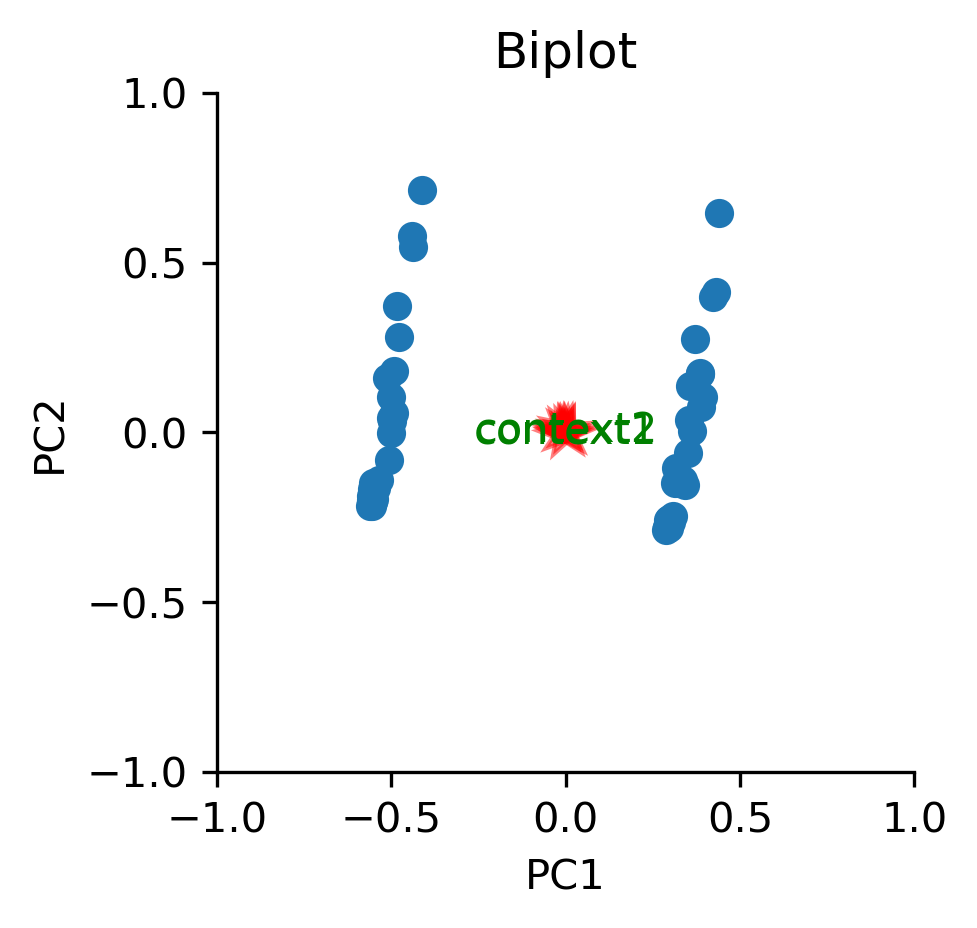

In [56]:
# same as above but with trees!

from utils import data
from hebbcl.parameters import parser
args = parser.parse_args(args=[])
args.n_episodes = 2
args.ctx_scaling = 6
args.centering = True
args.ctx_avg = False
# biplot
n_components = 27
%matplotlib inline
pca = PCA(n_components=n_components)
data = data.make_trees_dataset(args)

pca.fit(data['x_train'])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scores = data['x_train']@pca.components_.T
labels = ['']*(n_components-2) + ['context1'] + ['context2']
score = scores
coeff = pca.components_.T
pcax = 1
pcay =2

plt.figure(figsize=(3,3),dpi=300)

pca1=pcax-1
pca2=pcay-1
xs = score[:,pca1]
ys = score[:,pca2]
n=score.shape[1]
scalex = 1.0/(xs.max()- xs.min())
scaley = 1.0/(ys.max()- ys.min())
plt.scatter(xs*scalex,ys*scaley)
print(n)
for i in range(n):
    plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5, head_width=0.05) 
    if labels is None:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    else:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks(np.arange(-1,1.1,0.5))
plt.yticks(np.arange(-1,1.1,0.5))
plt.xlabel("PC{}".format(pcax))
plt.ylabel("PC{}".format(pcay))
# plt.grid()
sns.despine()
plt.title('Biplot')

In [29]:
# oja's rule 
eta = 4e-2
sigma = 1e-2
n_episodes = 1
n_trials = n_episodes*50
data = eval.make_blobs_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False)
w = np.random.randn(27)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(w))
X = data['x_train']
for x in X:
    y = w.T@x    
    dw = eta*y*(x-y*w.T)    
    w += dw
    delta_ws.append(dw)
    ws.append(deepcopy(w))

plt.figure(figsize=(3,2.5),dpi=300)
a = plt.plot([wi[-1] for wi in ws], color='orange')
b = plt.plot([wi[-2] for wi in ws], color='blue')
plt.legend(['1st task', '2nd task'],frameon=False)
plt.title("Task weights, Oja's rule")
plt.xlabel('iter')
plt.ylabel('weight value (a.u.)')
ax = plt.gca()
for loc in ['top','right']:
    ax.spines[loc].set_visible(False)
plt.ylim(-1,1)
plt.yticks(np.arange(-1,1.1,1))
plt.tight_layout()


AttributeError: module 'utils.eval' has no attribute 'make_blobs_dataset'

In [ ]:
# fast vectorised Oja's rule (for entire hidden layer)

# faster , no 2nd task knowledge during 1st
%matplotlib inline
eta = 2e-1
sigma = 1e-2
n_hidden = 100
n_episodes = 4
n_trials = n_episodes*50
data = eval.make_blobs_dataset(n_episodes=n_episodes,ctx_scaling=1,training_schedule='blocked',ctx_avg=False,centering=True)
W = np.random.randn(2,n_hidden)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(W))
X = data['x_train'][:,-2:]
X[X[:,0]>0,1] = 0


for x in X:    
    x_vec = np.tile(x[:,np.newaxis],100)    
    assert x_vec.T.shape == (100,2 )
    
    y = W.T@x
    
    dW = eta*y*(x_vec-y*W)    
    W += dW
    delta_ws.append(dW)
    ws.append(W)

plt.figure(figsize=(3,2.5),dpi=300)

a = plt.plot([wi[-1] for wi in ws], color='orange',linewidth=1)
b = plt.plot([wi[-2] for wi in ws], color='blue',linewidth=1)
plt.legend([a[0], b[0]], ['1st task', '2nd task'], frameon=False)
plt.title('Task weights, Oja', fontsize=8)
plt.xlabel('iter')
plt.ylabel('weight')

plt.ylabel('weight value (a.u.)')
ax = plt.gca()
for loc in ['top','right']:
    ax.spines[loc].set_visible(False)
# plt.ylim(-0.15,0.15)
# plt.yticks(np.arange(-0.15,0.16,0.15))
plt.xlim([0,10])


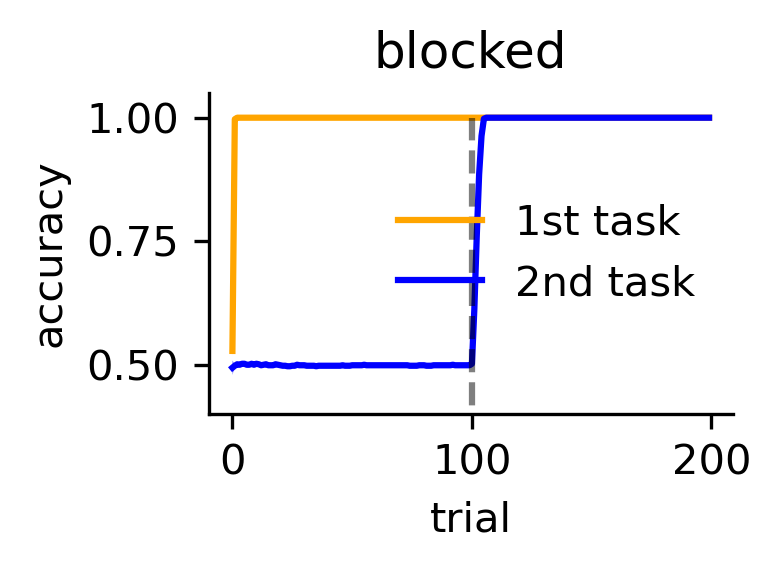

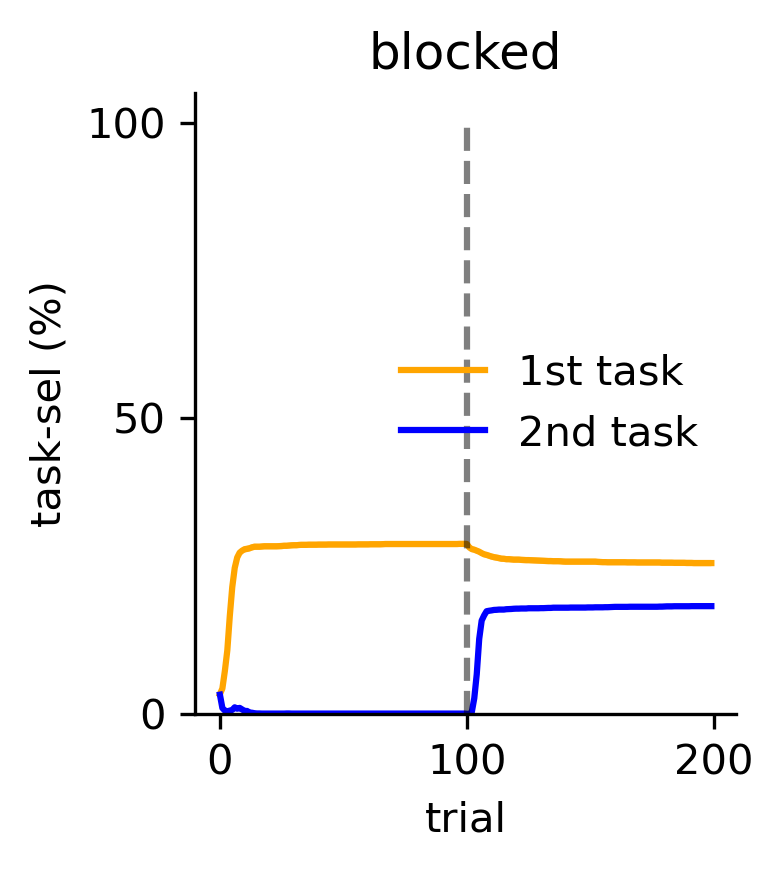

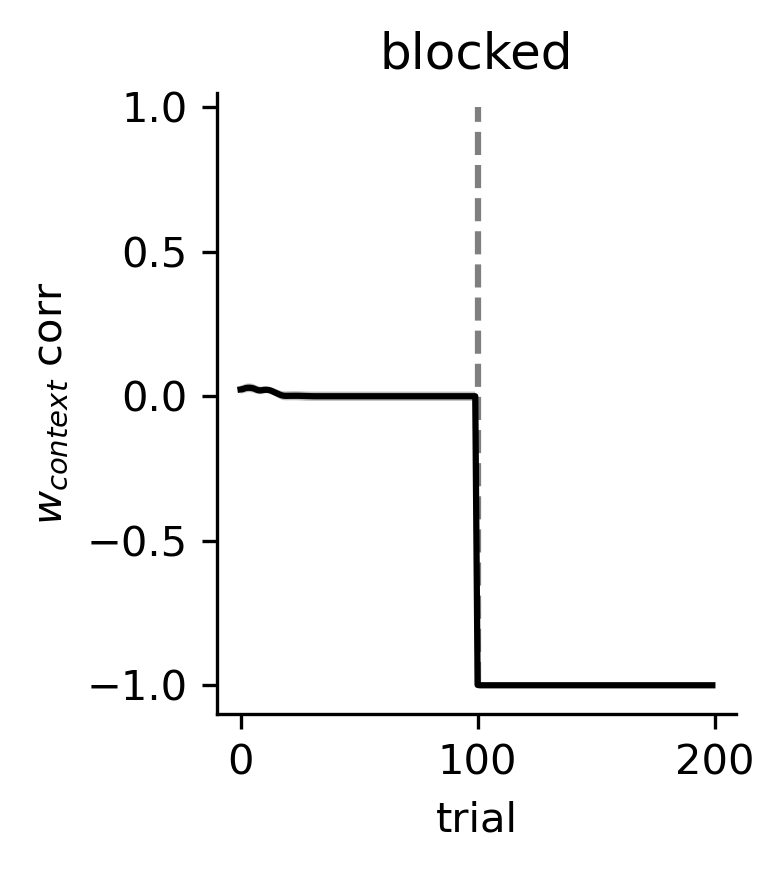

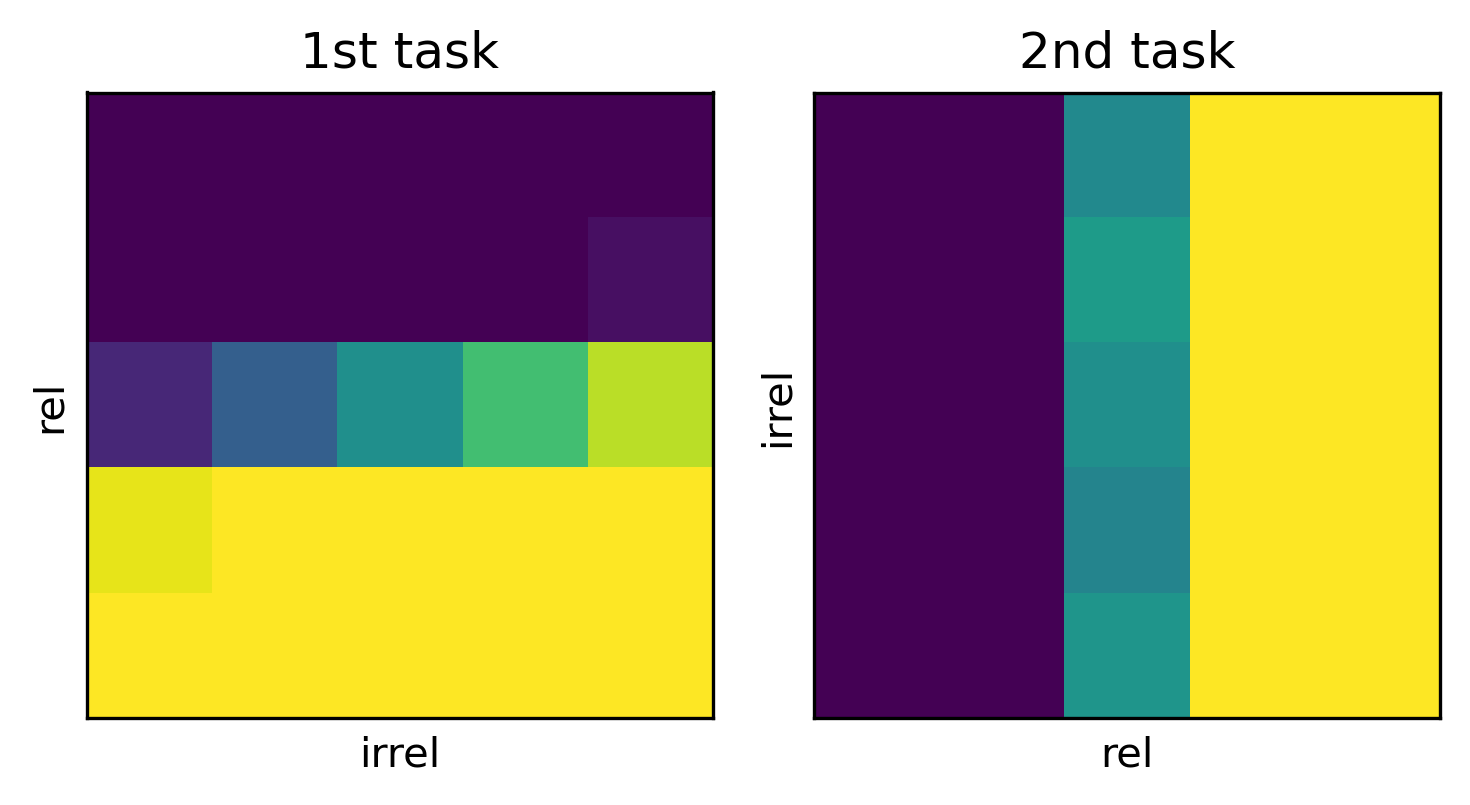

In [57]:
# learning curves 
%matplotlib inline
n_runs = 50
m = 'oja_blocked_new_select_halfcenter'
# m = "sluggish_oja_blocked_select_sv19"

# acc
f1, axs1 = plt.subplots(1,1,figsize=(2.7,2),dpi=300)
# # unit alloc
f2, axs2 = plt.subplots(1,1,figsize=(2.7,3),dpi=300)
# # context corr 
f3, axs3 = plt.subplots(1,1,figsize=(2.7,3),dpi=300)
# # choice matrices 
f4, axs4 = plt.subplots(1,2,figsize=(5,5),dpi=300)
# # hidden layer MDS, interleaved
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)
# # hidden layer MDS, blocked
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)



t_a = np.empty((n_runs,200))
t_b = np.empty((n_runs,200))
t_d = np.empty((n_runs,200))
t_mixed = np.empty((n_runs,200))
acc_1st = np.empty((n_runs,200))
acc_2nd = np.empty((n_runs,200))
contextcorr = np.empty((n_runs,200))
cmats_a = []
cmats_b = []

for r in range(n_runs):
    with open('../checkpoints/'+m+'/run_'+str(r)+'/results.pkl', 'rb') as f:
        results = pickle.load(f)
        
        # accuracy:
        acc_1st[r,:] = results['acc_1st']
        acc_2nd[r,:] = results['acc_2nd']
        # task factorisation:
        t_a[r,:] = results['n_only_b_regr']/100
        t_b[r,:] = results['n_only_a_regr']/100
        t_d[r,:] = results['n_dead']/100
        t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
        # context correlation:
        contextcorr[r,:] = results['w_context_corr']
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)

# accuracy
axs1.plot(np.arange(200),acc_1st.mean(0),color='orange')
axs1.fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
axs1.plot(np.arange(200),acc_2nd.mean(0),color='blue')
axs1.fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
axs1.set_ylim([0.4,1.05])
axs1.set(xlabel='trial', ylabel='accuracy')
axs1.legend(['1st task','2nd task'],frameon=False)
if 'interleaved' not in m:
    axs1.plot([100,100],[0,1],'k--',alpha=0.5)
axs1.set_title(m.split('_')[1])
plt.gcf()
sns.despine(f1)
f1.tight_layout()


# unit allocation (task factorisation)
axs2.plot(np.arange(200),t_b.mean(0),color='orange')
axs2.fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
axs2.plot(np.arange(200),t_a.mean(0),color='blue')
axs2.fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)    
axs2.set_yticks([0,0.5,1])
ticks = axs2.get_yticks()#plt.yticks()
axs2.set_yticklabels((int(x) for x in ticks*100))
axs2.set(xlabel='trial',ylabel='task-sel (%)')
axs2.legend(['1st task','2nd task'],frameon=False)
if 'interleaved' not in m:
    axs2.plot([100,100],[0,1],'k--',alpha=0.5)
axs2.set_title(m.split('_')[1])
plt.gcf()
sns.despine(f2)
axs2.set_ylim([0,1.05])    
f2.tight_layout()

# context corr 
axs3.plot(np.arange(200),contextcorr.mean(0),color='k')    
axs3.fill_between(np.arange(200),contextcorr.mean(0)-np.std(contextcorr,0)/np.sqrt(n_runs),contextcorr.mean(0)+np.std(contextcorr,0)/np.sqrt(n_runs),alpha=0.5,color='grey',edgecolor=None)

axs3.set_ylim([-1.1,1.05])
axs3.set(xlabel='trial',ylabel=r'$w_{context}$ corr ')    
if 'interleaved' not in m:
    axs3.plot([100,100],[-1,1],'k--',alpha=0.5)
axs3.set_title(m.split('_')[1])
sns.despine(f3)
f3.tight_layout()


# choice matrices 

axs4[0].imshow(cmats_a.mean(0))
axs4[0].set_title('1st task')
axs4[0].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='irrel',ylabel='rel')
axs4[1].imshow(cmats_b.mean(0))
axs4[1].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='rel',ylabel='irrel')
axs4[1].set_title('2nd task')
PCM=axs4[1].get_children()[-2] #get the mappable, the 1st and the 2nd are the x and y axes
axs4[0].set_xticks([])
axs4[0].set_yticks([])
axs4[1].set_xticks([])
axs4[1].set_yticks([])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(PCM,cax=cax) 



f1.tight_layout()
# f2.tight_layout()
# f3.tight_layout()
f4.tight_layout()
f4.set_facecolor('w')



In [ ]:
# hidden layer MDS

n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('../checkpoints/oja_blocked_new_select_halfcenter/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_oja_blocked_new_select_halfcenter.pkl','wb') as f:
#     pickle.dump(xyz, f)
# %matplotlib qt
with open('mds_embedding_oja_blocked_new_select_halfcenter.pkl','rb') as f:
    xyz = pickle.load(f)
%matplotlib inline
theta_x = -25
theta_y = 135+180-10
theta_z = 20

xyz_rot = eval.rotate(xyz,theta_x,axis='x')
xyz_rot = eval.rotate(xyz_rot,theta_y,axis='y')
xyz_rot = eval.rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=6.5)

## Figure 5: Modelling human learning with Oja + EMA

### HP Grid Search

In [ ]:
# model validation: fit to idealised choice matrices 
%matplotlib inline
_,_,mats = eval.gen_behav_models()
tmp_b = mats[0].ravel()[:,np.newaxis]
tmp_i = mats[1].ravel()[:,np.newaxis]
plt.subplot(1,2,1)
plt.imshow(tmp_b.reshape(10,5))
plt.title('blocked model')
plt.subplot(1,2,2)
plt.imshow(tmp_i.reshape(10,5))
plt.title('interleaved model')

mses_b = choicemodel.gridsearch_modelparams(tmp_b, curriculum="blocked")
plt.figure()
plt.imshow(np.fliplr(np.array(mses_b).reshape(20,20)))
plt.xlabel('sluggishness')
plt.ylabel('slope')
plt.title('blocked model')
plt.colorbar()
mses_i = choicemodel.gridsearch_modelparams(tmp_i, curriculum="interleaved")
plt.figure()
plt.imshow(np.fliplr(np.array(mses_i).reshape(20,20)))
plt.xlabel('sluggishness')
plt.ylabel('slope')
plt.title('interleaved model')
plt.colorbar()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(mses_b).reshape(20,20).mean(1),color='lightgreen',linestyle='-')
plt.plot(np.array(mses_i).reshape(20,20).mean(1),color='orange',linestyle='-')
plt.scatter(np.where(np.array(mses_b).reshape(20,20).mean(1)==np.min(np.array(mses_b).reshape(20,20).mean(1)))[0][0],np.min(np.array(mses_b).reshape(20,20).mean(1)),marker='d',s=100,color='lightgreen')
plt.scatter(np.where(np.array(mses_i).reshape(20,20).mean(1)==np.min(np.array(mses_i).reshape(20,20).mean(1)))[0][0],np.min(np.array(mses_i).reshape(20,20).mean(1)),marker='d',s=100,color='orange')
plt.legend(('blocked','interleaved'))
plt.xlabel('slope')
plt.ylabel('mse')
plt.subplot(1,2,2)
plt.plot(np.flip(np.array(mses_b).reshape(20,20).mean(0)),color='lightgreen',linestyle='-')
plt.plot(np.flip(np.array(mses_i).reshape(20,20).mean(0)),color='orange',linestyle='-')
plt.scatter(np.where(np.flip(np.array(mses_b).reshape(20,20).mean(0))==np.min(np.flip(np.array(mses_b).reshape(20,20).mean(0))))[0][0],np.min(np.flip(np.array(mses_b).reshape(20,20).mean(0))),marker='d',s=100,color='lightgreen')
plt.scatter(np.where(np.flip(np.array(mses_i).reshape(20,20).mean(0))==np.min(np.flip(np.array(mses_i).reshape(20,20).mean(0))))[0][0],np.min(np.flip(np.array(mses_i).reshape(20,20).mean(0))),marker='d',s=100,color='orange')
plt.legend(('blocked','interleaved'))
plt.xlabel('sluggishness')
plt.ylabel('mse')

In [ ]:
# grid search at single subject level
gs_results = choicemodel.wrapper_gridsearch_modelparams()
plt.figure()
plt.imshow(np.fliplr(gs_results['cmat_b'].reshape(-1,20,20).mean(0)))
plt.xlabel('sluggishness')
plt.ylabel('slope')
plt.title('single subject lvl, blocked')
plt.colorbar()

plt.figure()
plt.imshow(np.fliplr(gs_results['cmat_i'].reshape(-1,20,20).mean(0)))
plt.xlabel('sluggishness')
plt.ylabel('slope')
plt.title('single subject lvl, interleaved')
plt.colorbar()


# averages
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1),color='lightgreen',linestyle='-')
plt.plot(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1),color='orange',linestyle='-')
plt.scatter(np.where(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1)==np.min(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1)))[0][0],np.min(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1)),marker='d',s=100,color='lightgreen')
plt.scatter(np.where(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1)==np.min(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1)))[0][0],np.min(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1)),marker='d',s=100,color='orange')
plt.title('sigmoid slope')
plt.xlabel('param val')
plt.ylabel('mse')
plt.legend(('blocked','interleaved'))
plt.subplot(1,2,2)
plt.plot(np.flip(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0)),color='lightgreen',linestyle='-')
plt.plot(np.flip(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0)),color='orange',linestyle='-')
plt.scatter(np.where(np.flip(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0))==np.min(np.flip(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0))))[0][0],np.min(np.flip(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0))),marker='d',s=100,color='lightgreen')
plt.scatter(np.where(np.flip(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0))==np.min(np.flip(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0))))[0][0],np.min(np.flip(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0))),marker='d',s=100,color='orange')
plt.title('sluggishness')
plt.xlabel('param val')
plt.ylabel('mse')
plt.legend(('blocked','interleaved'))
plt.tight_layout()

In [ ]:
print(f"estimated sluggishness (idx), interleaved: {np.argmin(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0))}")
print(f"estimated sluggishness (idx), blocked: {np.argmin(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0))}")
print(f"estimated slope (idx), interleaved: {np.argmin(gs_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1))}")
print(f"estimated slope (idx), blocked: {np.argmin(gs_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1))}")
# np.logspace(np.log(0.1), np.log(4), 20)[12]

In [ ]:
%matplotlib inline
# grid search at group level 
gs_m_results = choicemodel.wrapper_gridsearch_modelparams(single_subs=False)
plt.figure()
plt.imshow(np.fliplr(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0)))
plt.xlabel('sluggishness')
plt.ylabel('slope')
plt.title('single subject lvl, blocked')
plt.colorbar()

plt.figure()
plt.imshow(np.fliplr(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0)))
plt.xlabel('sluggishness')
plt.ylabel('slope')
plt.title('single subject lvl, interleaved')
plt.colorbar()


# averages
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1),color='lightgreen',linestyle='-')
plt.plot(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1),color='orange',linestyle='-')
plt.scatter(np.where(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1)==np.min(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1)))[0][0],np.min(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(1)),marker='d',s=100,color='lightgreen')
plt.scatter(np.where(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1)==np.min(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1)))[0][0],np.min(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(1)),marker='d',s=100,color='orange')
plt.title('sigmoid slope')
plt.xlabel('param val')
plt.ylabel('mse')
plt.legend(('blocked','interleaved'))
plt.subplot(1,2,2)
plt.plot(np.flip(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0)),color='lightgreen',linestyle='-')
plt.plot(np.flip(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0)),color='orange',linestyle='-')
plt.scatter(np.where(np.flip(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0))==np.min(np.flip(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0))))[0][0],np.min(np.flip(gs_m_results['cmat_b'].reshape(-1,20,20).mean(0).mean(0))),marker='d',s=100,color='lightgreen')
plt.scatter(np.where(np.flip(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0))==np.min(np.flip(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0))))[0][0],np.min(np.flip(gs_m_results['cmat_i'].reshape(-1,20,20).mean(0).mean(0))),marker='d',s=100,color='orange')
plt.title('sluggishness')
plt.xlabel('param val')
plt.ylabel('mse')
plt.legend(('blocked','interleaved'))
plt.tight_layout()

In [ ]:
print(f"estimated sluggishness (idx), interleaved: {np.argmin(gs_m_results['cmat_i'].reshape(20,20).mean(0))}")
print(f"estimated sluggishness (idx), blocked: {np.argmin(gs_m_results['cmat_b'].reshape(20,20).mean(0))}")
print(f"estimated slope (idx), interleaved: {np.argmin(gs_m_results['cmat_i'].reshape(20,20).mean(1))}")
print(f"estimated slope (idx), blocked: {np.argmin(gs_m_results['cmat_b'].reshape(20,20).mean(1))}")

### Accuracy

In [ ]:
# sanity check: calculate accuracy for ground truth matrices (should be 100% for fact and 80% for lin):
_,_,cmats = eval.gen_behav_models()
cmat_fact_a = cmats[0,0,:,:]
cmat_fact_b = cmats[0,1,:,:]
cmat_lin_a = cmats[1,0,:,:]
cmat_lin_b = cmats[1,1,:,:]

acc_fact = choicemodel.compute_sampled_accuracy(cmat_fact_a, cmat_fact_b)
acc_lin = choicemodel.compute_sampled_accuracy(cmat_lin_a, cmat_lin_b)
print(f"accuracy blocked: {acc_fact:.2f}, accuracy interleaved: {acc_lin:.2f}")


In [ ]:
n_runs = 20
idx = 1
tempval_interleaved = 12
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/sluggish_oja_int_select_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_interleaved)
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_a = np.array(cmats_a).mean(0)
cmats_b = np.array(cmats_b).mean(0)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cmats_a)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cmats_b)
plt.colorbar()
acc_est = choicemodel.compute_sampled_accuracy(cmats_a, cmats_b)
print(f"accuracy blocked: {acc_est:.2f}")


In [ ]:
from scipy.stats import norm, ttest_ind
%matplotlib inline
#load slugglish sla int , collect accuracies
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.1
idx = np.where(sluggish_vals==alpha)[0][0]
tempidx_blocked = 14
tempval_blocked = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_blocked]
tempidx_interleaved = 14
tempval_interleaved = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_interleaved]
n_runs = 20 

# sample from oja models to compute accuracy:
# acc_a = []
# acc_b = []
# for r in np.arange(0,n_runs):
#     with open('../checkpoints/sluggish_oja_int_select_sv'+ str(idx) + '/run_' + str(r) +'/results.pkl','rb') as f:
#         results = pickle.load(f)
#         acc_a.append(results['acc_1st'][-1])
#         acc_b.append(results['acc_2nd'][-1])
# acc_int_sla = (np.array(acc_a)+np.array(acc_b))/2

acc_int_sla = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/sluggish_oja_int_select_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_interleaved)        
        acc_int_sla.append(choicemodel.compute_sampled_accuracy(choices[:25].reshape(5,5), choices[25:].reshape(5,5)))
acc_int_sla = np.array(acc_int_sla)


# load sluggish sla blocked, collect accuracies
# acc_a = []
# acc_b = []
# for r in np.arange(0,n_runs):
#     with open('../checkpoints/oja_blocked_new_select_halfcenter/run_' + str(r) +'/results.pkl','rb') as f:
#         results = pickle.load(f)
#         # acc_a.append(results['acc_1st_noise'][-1][6])
#         acc_a.append(results['acc_1st'][-1])
#         # acc_b.append(results['acc_2nd_noise'][-1][6])
#         acc_b.append(results['acc_2nd'][-1])
# acc_blocked_sla = (np.array(acc_a)+np.array(acc_b))/2

acc_blocked_sla = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/oja_blocked_new_select_halfcenter"
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_interleaved)        
        acc_blocked_sla.append(choicemodel.compute_sampled_accuracy(choices[:25].reshape(5,5), choices[25:].reshape(5,5)))
acc_blocked_sla = np.array(acc_blocked_sla)

# load baseline models:
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('../checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        # acc_a.append(results['acc_1st_noise'][-1][6])
        acc_a.append(results['acc_1st'][-1])
        # acc_b.append(results['acc_2nd_noise'][-1][6])
        acc_b.append(results['acc_2nd'][-1])
acc_int_baseline = (np.array(acc_a)+np.array(acc_b))/2
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('../checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        # acc_a.append(results['acc_1st_noise'][-1][6])
        acc_a.append(results['acc_1st'][-1])
        # acc_b.append(results['acc_2nd_noise'][-1][6])
        acc_b.append(results['acc_2nd'][-1])
acc_blocked_baseline = (np.array(acc_a)+np.array(acc_b))/2




plt.figure(figsize=(3.2,2.0),dpi=300)
# make figure 
plt.subplot(1,3,1)
accs = loadmat('../../data/pnas_paper/accs_exp1a.mat')
plt.bar(np.arange(2),[accs['acc_b200'].mean(),accs['acc_int'].mean()],yerr=[np.std(accs['acc_b200'])/np.sqrt(len(accs['acc_b200'].T)),np.std(accs['acc_int'])/np.sqrt(len(accs['acc_int'].T))],color=[[0.2,0.2,0.2],[0.5,0.5,0.5]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim(0.5,1.05)
plt.yticks(ticks=np.arange(0.4,1.1,0.2),labels=np.arange(40,101,20),fontsize=6)
plt.ylabel('accuracy (%)',fontsize=6)
# plt.xlabel('group',fontsize=6)
sns.despine()
# plt.legend([mod_bsl,mod_sla],['baseline nnet', 'sluggish SLA nnet'],frameon=False)
plt.title('Humans',fontsize=6)
# statistical inference:
res = ttest_ind(accs['acc_b200'].ravel(),accs['acc_int'].ravel())
z = res.statistic# norm.isf(res.pvalue/2)
print(f"acc humans blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[1,1],'k-', linewidth=1)
plt.text(0.5,1,sigstar,ha='center',fontsize=6)

plt.subplot(1,3,2)
plt.bar(np.arange(2),[acc_blocked_baseline.mean(),acc_int_baseline.mean()],yerr=[np.std(acc_blocked_baseline)/np.sqrt(n_runs),np.std(acc_int_baseline)/np.sqrt(n_runs)],color=['darkred','red'],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim(0.5,1.05)
plt.yticks(ticks=np.arange(0.4,1.1,0.2),labels=np.arange(40,101,20),fontsize=6)
plt.ylabel('accuracy (%)',fontsize=6)
# plt.xlabel('group',fontsize=6)
sns.despine()
plt.title('Baseline',fontsize=6)
# statistical inference:
res = ttest_ind(acc_blocked_baseline,acc_int_baseline)
z = res.statistic# norm.isf(res.pvalue/2)
print(f"acc baseline blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[1,1],'k-', linewidth=1)
plt.text(0.5,1,sigstar,ha='center',fontsize=6)

plt.subplot(1,3,3)
plt.bar(np.arange(2),[acc_blocked_sla.mean(),acc_int_sla.mean()],yerr=[np.std(acc_blocked_sla)/np.sqrt(n_runs),np.std(acc_int_sla)/np.sqrt(n_runs)],color=[[20/255, 78/255, 102/255],[50/255, 133/255, 168/255]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim(0.5,1.05)
plt.yticks(ticks=np.arange(0.4,1.1,0.2),labels=np.arange(40,101,20),fontsize=6)
plt.ylabel('accuracy (%)',fontsize=6)
# plt.xlabel('group',fontsize=6)
sns.despine()
plt.title('EMA+Hebb',fontsize=6)
# plt.plot([0,1],[1,1],'k-', linewidth=1)
# plt.text(0.5,1,'***',ha='center',fontsize=6)
# statistical inference:
res = ttest_ind(acc_blocked_sla,acc_int_sla)
z = res.statistic# norm.isf(res.pvalue/2)
print(f"acc oja blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[1,1],'k-', linewidth=1)
plt.text(0.5,1,sigstar,ha='center',fontsize=6)
plt.suptitle('Accuracy',fontsize=6)

plt.tight_layout()

### Sigmoids

In [ ]:

# sigmoids
sluggish_vals = np.round(np.linspace(0.05, 1, 20), 2)
# best fitting with baseline_int slug models:
# alpha = 0.25
# idx = np.where(alpha == sluggish_vals)[0][0]
# tempidx_blocked = 13
# tempval_blocked = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_blocked]
# tempidx_interleaved = 16
# tempval_interleaved = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_interleaved]
# n_runs = 50


# best fitting with oja slug models:
alpha = 0.1
idx = np.where(sluggish_vals==alpha)[0][0]
tempidx_blocked = 14
tempval_blocked = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_blocked]
tempidx_interleaved = 14
tempval_interleaved = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_interleaved]
n_runs = 20

plt.figure(figsize=(4.8, 2.3), dpi=300)

betas = {
    "humans": {"blocked": {"rel": [], "irrel": []}, "int": {"rel": [], "irrel": []}},
    "baseline": {"blocked": {"rel": [], "irrel": []}, "int": {"rel": [], "irrel": []}},
    "ema": {"blocked": {"rel": [], "irrel": []}, "int": {"rel": [], "irrel": []}},
}

choices = loadmat("../../data/pnas_paper/choices_exp1a.mat")
# fit betas to individual subjects
for k, v in choices.items():
    if "choices" in k:
        k = k.split("_")
        bs = []
        for y in v:
            bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
        if k[1] == "b200":
            betas["humans"]["blocked"][k[-1]] = np.asarray(bs)
        else:
            betas["humans"][k[1]][k[-1]] = np.asarray(bs)

plt.subplot(1, 3, 1)
choices = loadmat("../../data/pnas_paper/choices_exp1a.mat")
pl_bl_rel = plt.errorbar(
    np.arange(5),
    choices["choices_b200_rel"].mean(0),
    yerr=np.std(choices["choices_b200_rel"].mean(0)) / np.sqrt(n_runs),
    marker="o",
    color=(0.2, 0.2, 0.2),
    markersize=4,
    linestyle="",
)
pl_bl_irrel = plt.errorbar(
    np.arange(5),
    choices["choices_b200_irrel"].mean(0),
    yerr=np.std(choices["choices_b200_irrel"].mean(0)) / np.sqrt(n_runs),
    marker="*",
    color=(0.2, 0.2, 0.2),
    linestyle="",
    markersize=4,
)
f_bl_rel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices["choices_b200_rel"].mean(0))
    ),
    color=(0.2, 0.2, 0.2),
    linestyle="-",
)
f_bl_irrel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices["choices_b200_irrel"].mean(0))
    ),
    color=(0.2, 0.2, 0.2),
    linestyle="--",
)

pl_in_rel = plt.errorbar(
    np.arange(5),
    choices["choices_int_rel"].mean(0),
    yerr=np.std(choices["choices_int_rel"].mean(0)) / np.sqrt(n_runs),
    marker="o",
    color=(0.5, 0.5, 0.5),
    markersize=4,
    linestyle="",
)
pl_in_irrel = plt.errorbar(
    np.arange(5),
    choices["choices_int_irrel"].mean(0),
    yerr=np.std(choices["choices_int_irrel"].mean(0)) / np.sqrt(n_runs),
    marker="*",
    color=(0.5, 0.5, 0.5),
    linestyle="",
    markersize=4,
)
f_bl_rel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices["choices_int_rel"].mean(0))
    ),
    color=(0.5, 0.5, 0.5),
    linestyle="-",
)
f_bl_irrel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices["choices_int_irrel"].mean(0))
    ),
    color=(0.5, 0.5, 0.5),
    linestyle="--",
)

sns.despine()
plt.legend(
    [pl_bl_rel[0], pl_bl_irrel[0], pl_in_rel[0], pl_in_irrel[0]],
    ["blocked - rel", "blocked - irrel", "int - rel", "int - irrel"],
    frameon=False,
    fontsize=6,loc=2
)
plt.title("Humans", fontsize=6)
plt.xlabel("feature value", fontsize=6)
plt.ylabel("p(accept)", fontsize=6)
plt.xticks(ticks=[0, 2, 4], labels=[1, 3, 5], fontsize=6)
plt.yticks(ticks=(0, 0.5, 1), fontsize=6)


plt.subplot(1, 3, 2)
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/baseline_interleaved_new/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        # choices = choice_sigmoid(cc,T=tempval)
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1)) / 2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2)) / 2
bs = []
for y in choices_rel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["baseline"]["int"]["rel"] = np.asarray(bs)
bs = []
for y in choices_irrel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["baseline"]["int"]["irrel"] = np.asarray(bs)

pl_in_rel = plt.errorbar(
    np.arange(5),
    choices_rel.mean(0),
    yerr=np.std(choices_rel.mean(0)) / np.sqrt(n_runs),
    marker="d",
    color="red",
    markersize=4,
    linestyle="",
)
pl_in_irrel = plt.errorbar(
    np.arange(5),
    choices_irrel.mean(0),
    yerr=np.std(choices_irrel.mean(0)) / np.sqrt(n_runs),
    marker="*",
    color="red",
    linestyle="",
    markersize=4,
)
f_bl_rel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_rel.mean(0))
    ),
    color="red",
    linestyle="-",
)
f_bl_irrel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_irrel.mean(0))
    ),
    color="red",
    linestyle="--",
)
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/baseline_blocked_new/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        # choices = choice_sigmoid(cc,T=tempval)
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1)) / 2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2)) / 2
bs = []
for y in choices_rel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["baseline"]["blocked"]["rel"] = np.asarray(bs)
bs = []
for y in choices_irrel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["baseline"]["blocked"]["irrel"] = np.asarray(bs)

pl_bl_rel = plt.errorbar(
    np.arange(5),
    choices_rel.mean(0),
    yerr=np.std(choices_rel.mean(0)) / np.sqrt(n_runs),
    marker="d",
    color="darkred",
    markersize=4,
    linestyle="",
)
pl_bl_irrel = plt.errorbar(
    np.arange(5),
    choices_irrel.mean(0),
    yerr=np.std(choices_irrel.mean(0)) / np.sqrt(n_runs),
    marker="*",
    color="darkred",
    linestyle="",
    markersize=4,
)
f_bl_rel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_rel.mean(0))
    ),
    color="darkred",
    linestyle="-",
)
f_bl_irrel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_irrel.mean(0))
    ),
    color="darkred",
    linestyle="--",
)
plt.legend(
    [pl_bl_rel[0], pl_bl_irrel[0], pl_in_rel[0], pl_in_irrel[0]],
    ["blocked - rel", "blocked - irrel", "int - rel", "int - irrel"],
    frameon=False,
    fontsize=6,loc=2
)
plt.title("Baseline", fontsize=6)
plt.xlabel("feature value", fontsize=6)
plt.ylabel("p(accept)", fontsize=6)
plt.xticks(ticks=[0, 2, 4], labels=[1, 3, 5], fontsize=6)
plt.yticks(ticks=(0, 0.5, 1), fontsize=6)


plt.subplot(1, 3, 3)
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/sluggish_oja_int_select_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_interleaved)
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1)) / 2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2)) / 2

for y in choices_rel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["ema"]["int"]["rel"] = np.asarray(bs)
bs = []
for y in choices_irrel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["ema"]["int"]["irrel"] = np.asarray(bs)


pl_in_rel = plt.errorbar(
    np.arange(5),
    choices_rel.mean(0),
    yerr=np.std(choices_rel.mean(0)) / np.sqrt(n_runs),
    marker="o",
    color=[50 / 255, 133 / 255, 168 / 255],
    markersize=4,
    linestyle="",
)
pl_in_irrel = plt.errorbar(
    np.arange(5),
    choices_irrel.mean(0),
    yerr=np.std(choices_irrel.mean(0)) / np.sqrt(n_runs),
    marker="*",
    color=[50 / 255, 133 / 255, 168 / 255],
    linestyle="",
    markersize=4,
)
f_in_rel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_rel.mean(0))
    ),
    color=[50 / 255, 133 / 255, 168 / 255],
    linestyle="-",
)
f_in_irrel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_irrel.mean(0))
    ),
    color=[50 / 255, 133 / 255, 168 / 255],
    linestyle="--",
)
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/oja_blocked_new_select_halfcenter/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_blocked)
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1)) / 2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2)) / 2
for y in choices_rel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["ema"]["blocked"]["rel"] = np.asarray(bs)
bs = []
for y in choices_irrel:
    bs.append(choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), y, fitlapse=False))
betas["ema"]["blocked"]["irrel"] = np.asarray(bs)
pl_bl_rel = plt.errorbar(
    np.arange(5),
    choices_rel.mean(0),
    yerr=np.std(choices_rel.mean(0)) / np.sqrt(n_runs),
    marker="o",
    color=[20 / 255, 78 / 255, 102 / 255],
    markersize=4,
    linestyle="",
)
pl_bl_irrel = plt.errorbar(
    np.arange(5),
    choices_irrel.mean(0),
    yerr=np.std(choices_irrel.mean(0)) / np.sqrt(n_runs),
    marker="*",
    color=[20 / 255, 78 / 255, 102 / 255],
    linestyle="",
    markersize=4,
)
f_bl_rel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_rel.mean(0))
    ),
    color=[20 / 255, 78 / 255, 102 / 255],
    linestyle="-",
)
f_bl_irrel = plt.plot(
    np.linspace(0, 4, 100),
    choicemodel.sigmoid(
        np.linspace(-2, 2, 100),
        *choicemodel.fit_sigmoid(zscore(np.arange(-2, 3)), choices_irrel.mean(0))
    ),
    color=[20 / 255, 78 / 255, 102 / 255],
    linestyle="--",
)

sns.despine()
plt.legend(
    [pl_bl_rel[0], pl_bl_irrel[0], pl_in_rel[0], pl_in_irrel[0]],
    ["blocked - rel", "blocked - irrel", "int - rel", "int - irrel"],
    frameon=False,
    fontsize=6,loc=2
)
plt.title("EMA+Hebb", fontsize=6)
plt.xlabel("feature value", fontsize=6)
plt.ylabel("p(accept)", fontsize=6)
plt.xticks(ticks=[0, 2, 4], labels=[1, 3, 5], fontsize=6)
plt.yticks(ticks=(0, 0.5, 1), fontsize=6)
plt.suptitle("Choices", fontsize=6)
plt.tight_layout()


In [ ]:
# betas

plt.figure(figsize=(3.2, 2.0), dpi=300)
# make figure
plt.subplot(1, 3, 1)

plt.bar(
    np.arange(2),
    [
        betas["humans"]["blocked"]["rel"][:, 1].mean(),
        betas["humans"]["int"]["rel"][:, 1].mean(),
    ],
    yerr=[
        np.std(betas["humans"]["blocked"]["rel"][:, 1])
        / np.sqrt(len(betas["humans"]["blocked"]["rel"][:, 1].T)),
        np.std(betas["humans"]["int"]["rel"][:, 1])
        / np.sqrt(len(betas["humans"]["int"]["rel"][:, 1].T)),
    ],
    color=[[0.2, 0.2, 0.2], [0.5, 0.5, 0.5]],
    width=0.8,
)
plt.xticks(ticks=[0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
plt.ylabel("slope (a.u.)", fontsize=6)
plt.yticks(fontsize=6)
sns.despine()
plt.title("Humans", fontsize=6)
res = ttest_ind(betas["humans"]["blocked"]["rel"][:,1],betas["humans"]["int"]["rel"][:,1])
z = res.statistic # norm.isf(res.pvalue/2)
print(z)
print(f"betas rel humans blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[6,6],'k-', linewidth=1)
plt.text(0.5,6,sigstar,ha='center',fontsize=6)


plt.subplot(1, 3, 2)
plt.bar(
    np.arange(2),
    [
        betas["baseline"]["blocked"]["rel"][:, 1].mean(),
        betas["baseline"]["int"]["rel"][:, 1].mean(),
    ],
    yerr=[
        np.std(betas["baseline"]["blocked"]["rel"][:, 1])
        / np.sqrt(len(betas["baseline"]["blocked"]["rel"][:, 1].T)),
        np.std(betas["baseline"]["int"]["rel"][:, 1])
        / np.sqrt(len(betas["baseline"]["int"]["rel"][:, 1].T)),
    ],
    color=['darkred','red'],
    width=0.8,
)
plt.xticks(ticks=[0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
plt.ylabel("slope (a.u.)", fontsize=6)
plt.yticks(fontsize=6)
sns.despine()
plt.title("Baseline", fontsize=6)
res = ttest_ind(betas["baseline"]["blocked"]["rel"][:,1],betas["baseline"]["int"]["rel"][:,1])
z = res.statistic# norm.isf(res.pvalue/2)
print(f"betas rel baseline blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[11,11],'k-', linewidth=1)
plt.text(0.5,11,sigstar,ha='center',fontsize=6)

plt.subplot(1, 3, 3)
plt.bar(
    np.arange(2),
    [
        betas["ema"]["blocked"]["rel"][:, 1].mean(),
        betas["ema"]["int"]["rel"][:, 1].mean(),
    ],
    yerr=[
        np.std(betas["ema"]["blocked"]["rel"][:, 1])
        / np.sqrt(len(betas["ema"]["blocked"]["rel"][:, 1].T)),
        np.std(betas["ema"]["int"]["rel"][:, 1])
        / np.sqrt(len(betas["ema"]["int"]["rel"][:, 1].T)),
    ],
    color=[[20/255, 78/255, 102/255],[50/255, 133/255, 168/255]],
    width=0.8,
)
plt.xticks(ticks=[0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
plt.ylabel("slope (a.u.)", fontsize=6)
plt.yticks(fontsize=6)
sns.despine()

plt.title("EMA+Hebb", fontsize=6)
res = ttest_ind(betas["ema"]["blocked"]["rel"][:,1],betas["ema"]["int"]["rel"][:,1])
z = res.statistic# norm.isf(res.pvalue/2)
print(f"betas rel ema blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[3,3],'k-', linewidth=1)
plt.text(0.5,3,sigstar,ha='center',fontsize=6)
plt.suptitle('Slopes, relevant dimension',fontsize=6)
plt.tight_layout()


plt.suptitle('Slopes, relevant dimension',fontsize=6)
plt.tight_layout()


In [ ]:

plt.figure(figsize=(3.2, 2.0), dpi=300)
# make figure
plt.subplot(1, 3, 1)

plt.bar(
    np.arange(2),
    [
        betas["humans"]["blocked"]["irrel"][:, 1].mean(),
        betas["humans"]["int"]["irrel"][:, 1].mean(),
    ],
    yerr=[
        np.std(betas["humans"]["blocked"]["irrel"][:, 1])
        / np.sqrt(len(betas["humans"]["blocked"]["irrel"][:, 1].T)),
        np.std(betas["humans"]["int"]["irrel"][:, 1])
        / np.sqrt(len(betas["humans"]["int"]["irrel"][:, 1].T)),
    ],
    color=[[0.2, 0.2, 0.2], [0.5, 0.5, 0.5]],
    width=0.8,
)
plt.xticks(ticks=[0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
plt.ylabel("slope (a.u.)", fontsize=6)
plt.yticks(fontsize=6)
sns.despine()
plt.title("Humans", fontsize=6)
res = ttest_ind(betas["humans"]["blocked"]["irrel"][:,1],betas["humans"]["int"]["irrel"][:,1])
z = res.statistic#norm.isf(res.pvalue/2)
print(f"betas irrel humans blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
else: 
    sigstar = '*'*4
plt.plot([0,1],[0.4,0.4],'k-', linewidth=1)
plt.text(0.5,0.4,sigstar,ha='center',fontsize=6)

plt.subplot(1, 3, 2)
plt.bar(
    np.arange(2),
    [
        betas["baseline"]["blocked"]["irrel"][:, 1].mean(),
        betas["baseline"]["int"]["irrel"][:, 1].mean(),
    ],
    yerr=[
        np.std(betas["baseline"]["blocked"]["irrel"][:, 1])
        / np.sqrt(len(betas["baseline"]["blocked"]["irrel"][:, 1].T)),
        np.std(betas["baseline"]["int"]["irrel"][:, 1])
        / np.sqrt(len(betas["baseline"]["int"]["irrel"][:, 1].T)),
    ],
    color=['darkred','red'],
    width=0.8,
)
plt.xticks(ticks=[0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
plt.ylabel("slope (a.u.)", fontsize=6)
plt.yticks(fontsize=6)
sns.despine()
plt.title("Baseline", fontsize=6)
res = ttest_ind(betas["baseline"]["blocked"]["irrel"][:,1],betas["baseline"]["int"]["irrel"][:,1])
z = res.statistic#norm.isf(res.pvalue/2)
print(f"betas irrel baseline blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
else: 
    sigstar = '*'*4
plt.plot([0,1],[1.2,1.2],'k-', linewidth=1)
plt.text(0.5,1.2,sigstar,ha='center',fontsize=6)

plt.subplot(1, 3, 3)
plt.bar(
    np.arange(2),
    [
        betas["ema"]["blocked"]["irrel"][:, 1].mean(),
        betas["ema"]["int"]["irrel"][:, 1].mean(),
    ],
    yerr=[
        np.std(betas["ema"]["blocked"]["irrel"][:, 1])
        / np.sqrt(len(betas["ema"]["blocked"]["irrel"][:, 1].T)),
        np.std(betas["ema"]["int"]["irrel"][:, 1])
        / np.sqrt(len(betas["ema"]["int"]["irrel"][:, 1].T)),
    ],
    color=[[20/255, 78/255, 102/255],[50/255, 133/255, 168/255]],
    width=0.8,
)
plt.xticks(ticks=[0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
plt.ylabel("slope (a.u.)", fontsize=6)
plt.yticks(fontsize=6)
sns.despine()
plt.title("EMA+Hebb", fontsize=6)
res = ttest_ind(betas["ema"]["blocked"]["irrel"][:,1],betas["ema"]["int"]["irrel"][:,1])
z = res.statistic#norm.isf(res.pvalue/2)
print(f"betas irrel ema blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
else: 
    sigstar = '*'*4
plt.plot([0,1],[0.4,0.4],'k-', linewidth=1)
plt.text(0.5,0.4,sigstar,ha='center',fontsize=6)

plt.suptitle('Slopes, irrelevant dimension',fontsize=6)
plt.tight_layout()


### Choice Matrices

In [ ]:
# human cmats
n_runs = 20
sluggish_vals = np.round(np.linspace(0.05, 1, 20), 2)

# best fitting with baseline_int slug models:
# alpha = 0.25
# idx = np.where(alpha == sluggish_vals)[0][0]
# tempidx_blocked = 13
# tempval_blocked = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_blocked]
# tempidx_interleaved = 16
# tempval_interleaved = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_interleaved]
# n_runs = 50


# best fitting with oja slug models:
alpha = 0.1
idx = np.where(sluggish_vals==alpha)[0][0]
tempidx_blocked = 14
tempval_blocked = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_blocked]
tempidx_interleaved = 14
tempval_interleaved = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_interleaved]
n_runs = 20


cmats = loadmat("../../data/pnas_paper/choicemats_exp1a.mat", matlab_compatible=True)
ks = list(cmats.keys())
for k in ks:
    if not "cmat" in k:
        cmats.pop(k)
cmats_human = {
    "int_a": cmats["cmat_i_north"],
    "int_b": cmats["cmat_i_south"],
    "bloc_a": cmats["cmat_b_north"],
    "bloc_b": cmats["cmat_b_south"],
}

# baseline cmats
cmats_baseline = {}
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/baseline_interleaved_new/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_baseline["int_a"] = np.array(cmats_a)
cmats_baseline["int_b"] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/baseline_blocked_new/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_baseline["bloc_a"] = np.array(cmats_a)
cmats_baseline["bloc_b"] = np.array(cmats_b)


# ema+sla cmats
cmats_emasla = {}
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/sluggish_oja_int_select_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_interleaved)
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_emasla["int_a"] = np.array(cmats_a)
cmats_emasla["int_b"] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open("../checkpoints/oja_blocked_new_select_halfcenter/run_" + str(r) + "/results.pkl", "rb") as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_blocked)
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_emasla["bloc_a"] = np.array(cmats_a)
cmats_emasla["bloc_b"] = np.array(cmats_b)


In [ ]:
# task factorisation (behav)
betas_human = eval.compute_behav_taskfact(cmats_human)
betas_baseline = eval.compute_behav_taskfact(cmats_baseline)
betas_emasla = eval.compute_behav_taskfact(cmats_emasla)

In [ ]:
f = plt.figure(figsize=(4.8, 2.3), dpi=300)
plt.subplot(1, 3, 1)
# blocked
ha = plt.bar(
    0 - 0.2,
    np.mean(betas_human["bloc"][:, 0], 0),
    yerr=np.std(betas_human["bloc"][:, 0], 0)
    / np.sqrt(betas_human["bloc"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    0 + 0.2,
    np.mean(betas_human["bloc"][:, 1], 0),
    yerr=np.std(betas_human["bloc"][:, 1], 0)
    / np.sqrt(betas_human["bloc"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
# interleaved
ha = plt.bar(
    1 - 0.2,
    np.mean(betas_human["int"][:, 0], 0),
    yerr=np.std(betas_human["int"][:, 0], 0)
    / np.sqrt(betas_human["int"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    1 + 0.2,
    np.mean(betas_human["int"][:, 1], 0),
    yerr=np.std(betas_human["int"][:, 1], 0)
    / np.sqrt(betas_human["int"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
# stats factorised model
res = ttest_ind(betas_human['bloc'][:,0],betas_human['int'][:,0])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"humans factorised model blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
# stats linear models
res = ttest_ind(betas_human['bloc'][:,1],betas_human['int'][:,1])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"humans linear model blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")

# stats interaction (with bars)
res = ttest_ind(betas_human['bloc'][:,0]-betas_human['bloc'][:,1],betas_human['int'][:,0]-betas_human['int'][:,1])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"humans interaction blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[1,1],'k-', linewidth=1)
plt.text(0.5,1,sigstar,ha='center',fontsize=6)

sns.despine()
plt.legend([ha, hb], ("factorised model", "linear model"), frameon=False, fontsize=6)
plt.ylabel(r"$\beta$ coefficient (a.u.)", fontsize=6)
# plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title("Humans", fontsize=6)
plt.xticks([0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
ax = plt.gca()
plt.yticks(ticks = [0,0.25,0.5,0.75,1],labels=[0,0.25,0.5,0.75,1],fontsize=6)

plt.subplot(1, 3, 2)
# blocked
ha = plt.bar(
    0 - 0.2,
    np.mean(betas_baseline["bloc"][:, 0], 0),
    yerr=np.std(betas_baseline["bloc"][:, 0], 0)
    / np.sqrt(betas_baseline["bloc"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    0 + 0.2,
    np.mean(betas_baseline["bloc"][:, 1], 0),
    yerr=np.std(betas_baseline["bloc"][:, 1], 0)
    / np.sqrt(betas_baseline["bloc"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
# interleaved
ha = plt.bar(
    1 - 0.2,
    np.mean(betas_baseline["int"][:, 0], 0),
    yerr=np.std(betas_baseline["int"][:, 0], 0)
    / np.sqrt(betas_baseline["int"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    1 + 0.2,
    np.mean(betas_baseline["int"][:, 1], 0),
    yerr=np.std(betas_baseline["int"][:, 1], 0)
    / np.sqrt(betas_baseline["int"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)

# stats factorised model
res = ttest_ind(betas_baseline['bloc'][:,0],betas_baseline['int'][:,0])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"baseline factorised model blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
# stats linear models
res = ttest_ind(betas_baseline['bloc'][:,1],betas_baseline['int'][:,1])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"baseline linear model blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")

# stats interaction (with bars)
res = ttest_ind(betas_baseline['bloc'][:,0]-betas_baseline['bloc'][:,1],betas_baseline['int'][:,0]-betas_baseline['int'][:,1])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"baseline interaction blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[1,1],'k-', linewidth=1)
plt.text(0.5,1,sigstar,ha='center',fontsize=6)


sns.despine()
plt.legend([ha, hb], ("factorised model", "linear model"), frameon=False, fontsize=6)
plt.ylabel(r"$\beta$ coefficient (a.u.)", fontsize=6)
# plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title("Baseline", fontsize=6)
plt.xticks([0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
ax = plt.gca()
plt.yticks(ticks = [0,0.25,0.5,0.75,1],labels=[0,0.25,0.5,0.75,1],fontsize=6)

plt.subplot(1, 3, 3)
# blocked
ha = plt.bar(
    0 - 0.2,
    np.mean(betas_emasla["bloc"][:, 0], 0),
    yerr=np.std(betas_emasla["bloc"][:, 0], 0)
    / np.sqrt(betas_emasla["bloc"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    0 + 0.2,
    np.mean(betas_emasla["bloc"][:, 1], 0),
    yerr=np.std(betas_emasla["bloc"][:, 1], 0)
    / np.sqrt(betas_emasla["bloc"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
# interleaved
ha = plt.bar(
    1 - 0.2,
    np.mean(betas_emasla["int"][:, 0], 0),
    yerr=np.std(betas_emasla["int"][:, 0], 0)
    / np.sqrt(betas_emasla["int"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    1 + 0.2,
    np.mean(betas_emasla["int"][:, 1], 0),
    yerr=np.std(betas_emasla["int"][:, 1], 0)
    / np.sqrt(betas_emasla["int"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
sns.despine()
# stats factorised model
res = ttest_ind(betas_emasla['bloc'][:,0],betas_emasla['int'][:,0])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"oja factorised model blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
# stats linear models
res = ttest_ind(betas_emasla['bloc'][:,1],betas_emasla['int'][:,1])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"oja linear model blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")

# stats interaction (with bars)
res = ttest_ind(betas_emasla['bloc'][:,0]-betas_emasla['bloc'][:,1],betas_emasla['int'][:,0]-betas_emasla['int'][:,1])
z = res.statistic # norm.isf(res.pvalue/2)
print(f"oja interaction blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'

plt.plot([0,1],[1,1],'k-', linewidth=1)
plt.text(0.5,1,sigstar,ha='center',fontsize=6)

plt.legend([ha, hb], ("factorised model", "linear model"), frameon=False, fontsize=6)
plt.ylabel(r"$\beta$ coefficient (a.u.)", fontsize=6)
# plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title("EMA+Hebb", fontsize=6)
plt.xticks([0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
ax = plt.gca()
plt.yticks(ticks = [0,0.25,0.5,0.75,1],labels=[0,0.25,0.5,0.75,1],fontsize=6)


plt.tight_layout()


### Psychophysical Model

In [ ]:
# psychophys model 
# best fitting with baseline_int slug models:
# alpha = 0.25
# idx = np.where(alpha == sluggish_vals)[0][0]
# tempidx_blocked = 13
# tempval_blocked = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_blocked]
# tempidx_interleaved = 16
# tempval_interleaved = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_interleaved]
# n_runs = 20


# best fitting with oja slug models:
alpha = 0.1
idx = np.where(sluggish_vals==alpha)[0][0]
tempidx_blocked = 14
tempval_blocked = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_blocked]
tempidx_interleaved = 14
tempval_interleaved = np.logspace(np.log(0.1), np.log(4), 20)[tempidx_interleaved]
n_runs = 20

cmats = loadmat('../../data/pnas_paper/choicemats_exp1a.mat')
cmats.keys()
choicemats_humans = {
    'blocked': 
    {
        'task_a':cmats['cmat_b_south'], 
        'task_b':cmats['cmat_b_north']
    },
    'interleaved': 
    {
        'task_a':cmats['cmat_i_south'], 
        'task_b':cmats['cmat_i_north']
    }
}


choicemats_baseline = {
    'blocked': 
    {
        'task_a':[], 
        'task_b':[]
    },
    'interleaved': 
    {
        'task_a':[], 
        'task_b':[]
    }
}


choicemats_sla = {
    'blocked': 
    {
        'task_a':[], 
        'task_b':[]
    },
    'interleaved': 
    {
        'task_a':[], 
        'task_b':[]
    }
}

## baseline --------------------------------
n_runs = 20 

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('../checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_baseline['blocked']['task_b'] = np.array(cmats_a)
choicemats_baseline['blocked']['task_a'] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('../checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_baseline['interleaved']['task_b'] = np.array(cmats_a)
choicemats_baseline['interleaved']['task_a'] = np.array(cmats_b)

## oja ------------------------------------------
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
# alpha = 0.2
# idx = np.where(alpha==sluggish_vals)[0][0]
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('../checkpoints/oja_blocked_new_select_halfcenter/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        choices = choicemodel.choicemodel.choice_sigmoid(cc,T=tempval_blocked)
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_sla['blocked']['task_b'] = np.array(cmats_a)
choicemats_sla['blocked']['task_a'] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('../checkpoints/sluggish_oja_int_select_sv'+ str(idx) +'/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        choices = choicemodel.choice_sigmoid(cc,T=tempval_interleaved)
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_sla['interleaved']['task_b'] = np.array(cmats_a)
choicemats_sla['interleaved']['task_a'] = np.array(cmats_b)



thetas_humans = {}
for cur in ['blocked','interleaved']:
    thetas_humans[cur] = choicemodel.fit_model_to_subjects(choicemats_humans[cur],n_runs=1)

thetas_baseline = {}
for cur in ['blocked','interleaved']:
    thetas_baseline[cur] = choicemodel.fit_model_to_subjects(choicemats_baseline[cur],n_runs=1)

thetas_oja = {}
for cur in ['blocked','interleaved']:
    thetas_oja[cur] = choicemodel.fit_model_to_subjects(choicemats_sla[cur],n_runs=1)


all_thetas = {
    'humans':thetas_humans,
    'baseline':thetas_baseline,
    'emahebb':thetas_oja
}

# with open('../results/thetas_est.pkl','rb') as f:
#     all_thetas = pickle.load(f)

# all_thetas['emahebb'] = thetas_oja
with open('../results/thetas_est.pkl','wb') as f:
    pickle.dump(all_thetas, f)

In [ ]:
with open('../results/thetas_est.pkl','rb') as f:
    all_thetas = pickle.load(f)
disp_model_estimates(all_thetas['humans'], cols=([0.2, 0.2, 0.2], [0.5, 0.5, 0.5]))
disp_model_estimates(all_thetas['baseline'], cols=["darkred", "red"])
disp_model_estimates(all_thetas['emahebb'], cols=[[20/255, 78/255, 102/255],[50/255, 133/255, 168/255]])


### Congruency Effect

In [ ]:
_,_,cmats = eval.gen_behav_models()
cmat_a = cmats[0,0,:,:]
cmat_b = cmats[0,1,:,:]
# human
acc_congr_human = {}
curricula = ('bloc','int')
for c in curricula:
    acc_congr_human[c] = []
    for ii in range(len(cmats_human[c+'_a'])):
        c_a = cmats_human[c+'_a'][ii,:,:]
        c_b = cmats_human[c+'_b'][ii,:,:]
        # compute congruency effect:
        accc_a,acci_a = eval.compute_congruency_acc(c_a,cmat_a)
        accc_b,acci_b = eval.compute_congruency_acc(c_b,cmat_b)
        acc_congr_human[c].append([(accc_a+accc_b)/2 - (acci_a+acci_b)/2])
    acc_congr_human[c] = np.asarray(acc_congr_human[c])

# baseline 
acc_congr_baseline = {}
curricula = ('bloc','int')
for c in curricula:
    acc_congr_baseline[c] = []
    for ii in range(len(cmats_baseline[c+'_a'])):
        c_a = cmats_baseline[c+'_a'][ii,:,:]
        c_b = cmats_baseline[c+'_b'][ii,:,:]
        # compute congruency effect:
        accc_a,acci_a = eval.compute_congruency_acc(c_a,cmat_a)
        accc_b,acci_b = eval.compute_congruency_acc(c_b,cmat_b)
        acc_congr_baseline[c].append([(accc_a+accc_b)/2 - (acci_a+acci_b)/2])
    acc_congr_baseline[c] = np.asarray(acc_congr_baseline[c])

# ema+sla
acc_congr_emasla = {}
curricula = ('bloc','int')
for c in curricula:
    acc_congr_emasla[c] = []
    for ii in range(len(cmats_emasla[c+'_a'])):
        c_a = cmats_emasla[c+'_a'][ii,:,:]
        c_b = cmats_emasla[c+'_b'][ii,:,:]
        # compute congruency effect:
        accc_a,acci_a = eval.compute_congruency_acc(c_a,cmat_a)
        accc_b,acci_b = eval.compute_congruency_acc(c_b,cmat_b)
        acc_congr_emasla[c].append([(accc_a+accc_b)/2 - (acci_a+acci_b)/2])
    acc_congr_emasla[c] = np.asarray(acc_congr_emasla[c])

In [ ]:
plt.figure(figsize=(3.2,2.0),dpi=300)
# make figure 
plt.subplot(1,3,1)
accs = loadmat('../../data/pnas_paper/accs_exp1a.mat')
plt.bar(np.arange(2),[acc_congr_human['bloc'].mean(),acc_congr_human['int'].mean()],yerr=[np.std(acc_congr_human['bloc'])/np.sqrt(len(acc_congr_human['bloc'])),np.std(acc_congr_human['int'])/np.sqrt(len(acc_congr_human['int']))],color=[[0.2,0.2,0.2],[0.5,0.5,0.5]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim((0,0.5))
plt.yticks(ticks=plt.yticks()[0],labels=(int(x) for x in plt.yticks()[0]*100),fontsize=6)
plt.ylabel('accuracy difference (%)',fontsize=6)
sns.despine()
plt.title('Humans',fontsize=6)
res = ttest_ind(acc_congr_human['bloc'].ravel(), acc_congr_human['int'].ravel())
z = res.statistic#norm.isf(res.pvalue / 2)
print(f"humans, congruency blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar = "n.s."
elif res.pvalue < 0.001:
    sigstar = "*" * 3
elif res.pvalue < 0.01:
    sigstar = "*" * 2
elif res.pvalue < 0.05:
    sigstar = "*"
plt.plot([0, 1], [0.5, 0.5], "k-", linewidth=1)
plt.text(0.5, 0.5, sigstar, ha="center", fontsize=6)



plt.subplot(1,3,2)
plt.bar(np.arange(2),[acc_congr_baseline['bloc'].mean(),acc_congr_baseline['int'].mean()],yerr=[np.std(acc_congr_baseline['bloc'])/np.sqrt(len(acc_congr_baseline['bloc'])),np.std(acc_congr_baseline['int'])/np.sqrt(len(acc_congr_baseline['int']))],color=['darkred','red'],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.yticks(ticks=plt.yticks()[0],labels=(int(x) for x in plt.yticks()[0]*100),fontsize=6)
plt.ylabel('accuracy difference (%)',fontsize=6)
plt.ylim((0,0.5))
sns.despine()
plt.title('Baseline',fontsize=6)
res = ttest_ind(acc_congr_baseline['bloc'].ravel(), acc_congr_baseline['int'].ravel())
z = res.statistic#norm.isf(res.pvalue / 2)
print(f"baselines, congruency blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar = "n.s."
elif res.pvalue < 0.001:
    sigstar = "*" * 3
elif res.pvalue < 0.01:
    sigstar = "*" * 2
elif res.pvalue < 0.05:
    sigstar = "*"
plt.plot([0, 1], [0.5, 0.5], "k-", linewidth=1)
plt.text(0.5, 0.5, sigstar, ha="center", fontsize=6)



plt.subplot(1,3,3)
plt.bar(np.arange(2),[acc_congr_emasla['bloc'].mean(),acc_congr_emasla['int'].mean()],yerr=[np.std(acc_congr_emasla['bloc'])/np.sqrt(len(acc_congr_emasla['bloc'])),np.std(acc_congr_emasla['int'])/np.sqrt(len(acc_congr_emasla['int']))],color=[[20/255, 78/255, 102/255],[0.5/255, 133/255, 168/255]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim((0,0.5))
plt.yticks(ticks=plt.yticks()[0],labels=(int(x) for x in plt.yticks()[0]*100),fontsize=6)
plt.ylabel('accuracy difference (%)',fontsize=6)
sns.despine()
plt.title('EMA+Hebb',fontsize=6)
res = ttest_ind(acc_congr_emasla['bloc'].ravel(), acc_congr_emasla['int'].ravel())
z = res.statistic#norm.isf(res.pvalue / 2)
print(f"oja, congruency blocked vs interleaved: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar = "n.s."
elif res.pvalue < 0.001:
    sigstar = "*" * 3
elif res.pvalue < 0.01:
    sigstar = "*" * 2
elif res.pvalue < 0.05:
    sigstar = "*"
plt.plot([0, 1], [0.5, 0.5], "k-", linewidth=1)
plt.text(0.5, 0.5, sigstar, ha="center", fontsize=6)


plt.suptitle('Congruency Effect',fontsize=6)
plt.tight_layout()

## Figure 6: Neural predictions

### Hidden Layer RSA
Fit grid, orthogonal and diagonal model to data.  
Prediction: Orthogonal best in blocked, diagonal best in interleaved group

In [ ]:
n_runs = 20
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.05
idx = np.where(alpha==sluggish_vals)[0][0]

betas_blocked = []
betas_int = []
rdms, dmat = eval.gen_modelrdms(ctx_offset=1)


for r in np.arange(0,n_runs):
    with open('../checkpoints/oja_blocked_new_select_halfcenter/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
    y = zscore(squareform(pdist(results['all_y_hidden'][1,:,:]))[np.tril_indices(50, k=-1)]).flatten()
    lr = LinearRegression()
    lr.fit(dmat,y)
    betas_blocked.append(lr.coef_)
betas_blocked = np.asarray(betas_blocked)


for r in np.arange(0,n_runs):
    with open('../checkpoints/sluggish_oja_int_select_sv'+ str(idx) +'/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
    y = zscore(squareform(pdist(results['all_y_hidden'][1,:,:]))[np.tril_indices(50, k=-1)]).flatten()
    lr = LinearRegression()
    lr.fit(dmat,y)
    betas_int.append(lr.coef_)
betas_int = np.asarray(betas_int)

In [ ]:
%matplotlib inline
f, axs = plt.subplots(1,1,figsize=(2,2), dpi = 300)

b1 = axs.bar(0-0.2,betas_blocked[:,0].mean(0),yerr=np.std(betas_blocked[:,0],0)/np.sqrt(n_runs),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(0,betas_blocked[:,1].mean(0),yerr=np.std(betas_blocked[:,1],0)/np.sqrt(n_runs),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(0+0.2,betas_blocked[:,2].mean(0),yerr=np.std(betas_blocked[:,2],0)/np.sqrt(n_runs),color=(159/255, 45/255, 235/255),width=0.2)

b1 = axs.bar(1-0.2,betas_int[:,0].mean(0),yerr=np.std(betas_int[:,0],0)/np.sqrt(n_runs),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(1,betas_int[:,1].mean(0),yerr=np.std(betas_int[:,1],0)/np.sqrt(n_runs),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(1+0.2,betas_int[:,2].mean(0),yerr=np.std(betas_int[:,2],0)/np.sqrt(n_runs),color=(159/255, 45/255, 235/255),width=0.2)
axs.set_xticks((0,1))
axs.set_yticks((0,0.25,0.5,0.75,1))
axs.set_xticklabels(('blocked','interleaved'),rotation=0,fontsize=6)
axs.set_yticklabels([0,0.25,0.5,0.75,1],fontsize=6)
axs.set_title('Model RSA, Hidden Layer',fontsize=6)
axs.set_ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
axs.legend([b1,b2,b3],['grid','orthogonal','diagonal'],fontsize=6,frameon=False)

res = ttest_ind(betas_blocked[:,0].ravel(),betas_blocked[:,1].ravel())
z = res.statistic
print(f"blocked grid vs orth: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
plt.plot([-0.2,0],[0.75,0.75],'k-', linewidth=1)
plt.text(-0.1,0.75,sigstar,ha='center',fontsize=6)

res = ttest_ind(betas_blocked[:,1].ravel(),betas_blocked[:,2].ravel())
z = res.statistic
print(f"blocked orth vs diag: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
plt.plot([0, 0.2],[0.7,0.7],'k-', linewidth=1)
plt.text(0.1,0.7,sigstar,ha='center',fontsize=6)

res = ttest_ind(betas_int[:,0].ravel(),betas_int[:,2].ravel())
z = res.statistic
print(f"int grid vs diag: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
plt.plot([0.8,1.2],[0.94,0.94],'k-', linewidth=1)
plt.text(1,0.94,sigstar,ha='center',fontsize=6)

res = ttest_ind(betas_int[:,1].ravel(),betas_int[:,2].ravel())
z = res.statistic
print(f"int orth vs diag: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
plt.plot([1,1.2],[0.88,0.88],'k-', linewidth=1)
plt.text(1.1,0.88,sigstar,ha='center',fontsize=6)


sns.despine()
plt.tight_layout()

### Task Selectivity (%)

In [ ]:
blocked_n_only_a = []
blocked_n_only_b = []
blocked_n_mixed = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/oja_blocked_new_select/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
    blocked_n_only_a.append(results["n_only_a_regr"][-1])
    blocked_n_only_b.append(results["n_only_b_regr"][-1])
    blocked_n_mixed.append(100 - blocked_n_only_a[-1] - blocked_n_only_b[-1])

blocked_n_only_a = np.asarray(blocked_n_only_a)
blocked_n_only_b = np.asarray(blocked_n_only_b)
blocked_n_mixed = np.asarray(blocked_n_mixed)
print(f"blocked, task-specific: {blocked_n_only_a.mean()+blocked_n_only_b.mean()}")
print(f"blocked, task-agnostic: {blocked_n_mixed.mean()}")
int_n_only_a = []
int_n_only_b = []
int_n_mixed = []
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/sluggish_oja_int_select_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
    int_n_only_a.append(results["n_only_a_regr"][-1])
    int_n_only_b.append(results["n_only_b_regr"][-1])
    int_n_mixed.append(100 - int_n_only_a[-1] - int_n_only_b[-1])

int_n_only_a = np.asarray(int_n_only_a)
int_n_only_b = np.asarray(int_n_only_b)
int_n_mixed = np.asarray(int_n_mixed)
print(f"int, task-specific: {int_n_only_a.mean()+int_n_only_b.mean()}")
print(f"int, task-agnostic: {int_n_mixed.mean()}")
n_a = np.stack((blocked_n_only_a, int_n_only_a), axis=1)
n_b = np.stack((blocked_n_only_b, int_n_only_b), axis=1)
n_m = np.stack((blocked_n_mixed, int_n_mixed), axis=1)
f, ax = plt.subplots(figsize=(2, 2), dpi=300)
b1 = ax.bar(
    ["blocked", "interleaved"],
    n_a.mean(0),
    yerr=np.std(n_a, 0, ddof=1) / np.sqrt(n_runs),
    width=0.2,
)
b2 = ax.bar(
    ["blocked", "interleaved"],
    n_b.mean(0),
    yerr=np.std(n_a, 0, ddof=1) / np.sqrt(n_runs),
    bottom=n_a.mean(0),
    width=0.2,
)
b3 = ax.bar(
    ["blocked", "interleaved"],
    n_m.mean(0),
    yerr=np.std(n_a, 0, ddof=1) / np.sqrt(n_runs),
    bottom=n_b.mean(0) + n_a.mean(0),
    width=0.2,
)
ax.set_ylabel("hidden units (%)", fontsize=6)
ax.legend(
    [b1, b2, b3],
    ["1st task, rel. dim.", "2nd task, rel. dim.", "task agnostic"],
    fontsize=6,
    frameon=False,
)
ax.set_title("Hidden Unit Selectivity", fontsize=6)
sns.despine()

for item in (
    [ax.title, ax.xaxis.label, ax.yaxis.label]
    + ax.get_xticklabels()
    + ax.get_yticklabels()
    + ax.get_legend().get_texts()
):
    item.set_fontsize(6)


### Readout Magnitude

In [ ]:
import torch
from utils.eval import make_dmat

n_runs = 20
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.05
idx = np.where(alpha==sluggish_vals)[0][0]
data = eval.make_blobs_dataset()

dmat = make_dmat(data['f_all'])

readout_magnitude = np.empty((50,3))
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/sluggish_oja_int_select_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)

    yh = results['all_y_hidden'][1,:,:]
    selectivity_matrix = np.zeros((100, 6))
    for i_neuron in range(100):
        y_neuron = yh[:, i_neuron]
        lr = sm.OLS(zscore(y_neuron), dmat)
        regr_results = lr.fit()
        # if only a single regressor is significant, store that neuron's selectivity
        if np.sum(regr_results.tvalues > 1.96) == 1:
            selectivity_matrix[
                i_neuron,
                np.where(regr_results.tvalues == np.max(regr_results.tvalues))[0][
                    0
                ],
            ] = 1
    i_task_a = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 1)
        & (selectivity_matrix[:, 2] == 0)
        & (selectivity_matrix[:, 3] == 0)
    )
    i_task_b = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 0)
        & (selectivity_matrix[:, 2] == 1)
        & (selectivity_matrix[:, 3] == 0)
    )

    with open(
            "../checkpoints/sluggish_oja_int_select_sv"
            + str(idx)
            + "/run_"
            + str(r)
            + "/model.pkl",
            "rb",
        ) as f:
            model = pickle.load(f)
    wo = model.W_o.cpu().detach().numpy()
    
    readout_magnitude[r,0] = np.abs(wo[i_task_a]).mean() if sum(i_task_a) !=0 else 0
    readout_magnitude[r,1] = np.abs(wo[i_task_b]).mean() if sum(i_task_b) !=0 else 0
    readout_magnitude[r,2] = np.abs(wo[~((i_task_a==True) | (i_task_b==True))]).mean()
readout_magnitude_int = readout_magnitude


In [ ]:
import sys
sys.path.append(r'../hebbcl/')


with open(
    "../checkpoints/oja_blocked_new_select/run_" + str(r) + "/results.pkl", "rb"
) as f:
    results = pickle.load(f)


import torch
from utils.eval import make_dmat


data = eval.make_blobs_dataset()

dmat = make_dmat(data["f_all"])

readout_magnitude = np.empty((50, 3))
for r in np.arange(0, n_runs):
    with open(
        "../checkpoints/oja_blocked_new_select_halfcenter/run_" + str(r) + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)

    yh = results["all_y_hidden"][1, :, :]
    selectivity_matrix = np.zeros((100, 6))
    for i_neuron in range(100):
        y_neuron = yh[:, i_neuron]
        lr = sm.OLS(zscore(y_neuron), dmat)
        regr_results = lr.fit()
        # if only a single regressor is significant, store that neuron's selectivity
        if np.sum(regr_results.tvalues > 1.96) == 1:
            selectivity_matrix[
                i_neuron,
                np.where(regr_results.tvalues == np.max(regr_results.tvalues))[0][0],
            ] = 1
    i_task_a = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 1)
        & (selectivity_matrix[:, 2] == 0)
        & (selectivity_matrix[:, 3] == 0)
    )
    i_task_b = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 0)
        & (selectivity_matrix[:, 2] == 1)
        & (selectivity_matrix[:, 3] == 0)
    )

    with open("../checkpoints/oja_blocked_new_select_halfcenter/run_" + str(r) + "/model.pkl", "rb") as f:
        model = pickle.load(f)
    
    wo = model.W_o.cpu().detach().numpy()

    readout_magnitude[r, 0] = np.abs(wo[i_task_a]).mean() if sum(i_task_a) != 0 else 0
    readout_magnitude[r, 1] = np.abs(wo[i_task_b]).mean() if sum(i_task_b) != 0 else 0
    readout_magnitude[r, 2] = np.abs(
        wo[~((i_task_a == True) | (i_task_b == True))]
    ).mean()

readout_magnitude_blocked = readout_magnitude


In [ ]:
f, axs = plt.subplots(1,1,figsize=(2,2), dpi = 300)

b1 = axs.bar(0-0.2,readout_magnitude_blocked[:,0].mean(0),yerr=np.std(readout_magnitude_blocked[:,0],0)/np.sqrt(50),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(0,readout_magnitude_blocked[:,1].mean(0),yerr=np.std(readout_magnitude_blocked[:,1],0)/np.sqrt(50),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(0+0.2,readout_magnitude_blocked[:,2].mean(0),yerr=np.std(readout_magnitude_blocked[:,2],0)/np.sqrt(50),color=(159/255, 45/255, 235/255),width=0.2)

b1 = axs.bar(1-0.2,readout_magnitude_int[:,0].mean(0),yerr=np.std(readout_magnitude_int[:,0],0)/np.sqrt(20),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(1,readout_magnitude_int[:,1].mean(0),yerr=np.std(readout_magnitude_int[:,1],0)/np.sqrt(20),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(1+0.2,readout_magnitude_int[:,2].mean(0),yerr=np.std(readout_magnitude_int[:,2],0)/np.sqrt(20),color=(159/255, 45/255, 235/255),width=0.2)
axs.set_xticks((0,1))
axs.set_xticklabels(('blocked','interleaved'),rotation=0,fontsize=6)
# ticks = np.round(axs.get_yticks(),2)
# axs.set_yticklabels(ticks,fontsize=6)
plt.yticks(fontsize=6)
axs.set_title('Readout Weights',fontsize=6)
axs.set_ylabel(r'weight magnitude (a.u.)',fontsize=6)
axs.legend([b1,b2,b3],['1st task','2nd task','task agnostic'],fontsize=6,frameon=False)

res = ttest_ind(readout_magnitude_int[:,0].ravel(),readout_magnitude_int[:,2].ravel())
z = res.statistic
print(f"int 1st vs agnostic: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
plt.plot([0.8,1.2],[0.22,0.22],'k-', linewidth=1)
plt.text(1,0.22,sigstar,ha='center',fontsize=6)

res = ttest_ind(readout_magnitude_int[:,1].ravel(),readout_magnitude_int[:,2].ravel())
z = res.statistic
print(f"int 2nd vs agnostic: t={z:.2f}, p={res.pvalue:.4f}")
if res.pvalue >= 0.05:
    sigstar ='n.s.'
elif res.pvalue < 0.001:
    sigstar ='*'*3
elif res.pvalue < 0.01:
    sigstar ='*'*2
elif res.pvalue <0.05:
    sigstar ='*'
plt.plot([1,1.2],[0.19,0.19],'k-', linewidth=1)
plt.text(1.1,0.19,sigstar,ha='center',fontsize=6)
sns.despine()
plt.tight_layout()